# Multi-Template Matching
## Tutorial 3 : Speed up the execution !

This tutorial shows 2 simple ways to increase the speed of execution with template matching.  
This is especially interesting if you need to run the detection on many images !

## Citations
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
You are free to distribute and/or modify this tutorial, provided you attribute the author:  

Multi-Template Matching python package online tutorial - _III - Speed-up execution_  
Laurent Thomas - 2019   
https://github.com/multi-template-matching/MultiTemplateMatching-Python/blob/master/tutorials/Tutorial3-SpeedingUp.ipynb


## Let's code !

In [1]:
# Set the root of the repo as the working directory, when running the notebook locally to load the package locally too
# Not needed if the package was installed with pip
%cd ..

C:\Users\Laurent Thomas\Documents\repo-MTM-Python


In [ ]:
# Install matplotlib if not already installed
# it is used in this notebook, but is otherwise not an actual dependency of MTM
%pip install matplotlib

In [2]:
# 1st import the package and check its version
import MTM
from MTM import matchTemplates, drawBoxesOnRGB

import cv2
from skimage.data import coins
import matplotlib.pyplot as plt

In [3]:
print("MTM version: ", MTM.__version__)

MTM version:  1.6.0


Let's open some test image (from the GitHub repository).  
This is a widefield microscopy image of a zebrafish larvae, mounted in a 96 well plate using agar.  
We will use Multi-Template-Matching for the detection of the head.  
This is useful since the larvae are not positioned exactly at the same spot in every well.  
For this tutorial we will use the same image though, as the goal is to compare the performance for different parameters.  

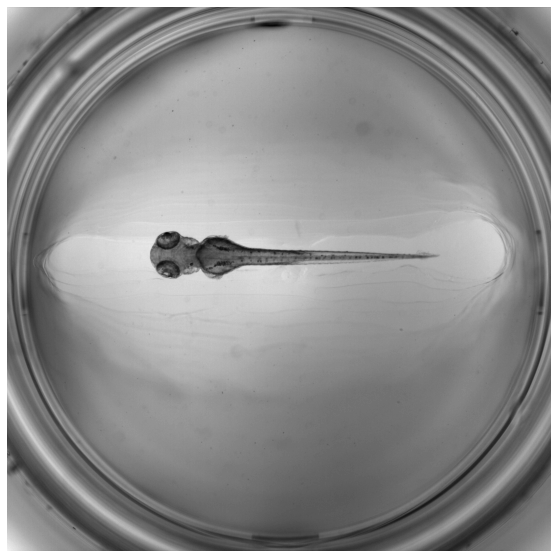

In [4]:
image = cv2.imread(r"./images/Fish.tif", -1) # this assume you cloned the repo, or you run the notebook from Binder. You can also download the image separatly
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(image, cmap="gray")

As usually we define a template to search.  
Here we will crop the template from the image to be searched, in practice it is not a realistic scenario, one would would usually have a generic template different from the searched image.  
But here the point is to show the difference in computation time.

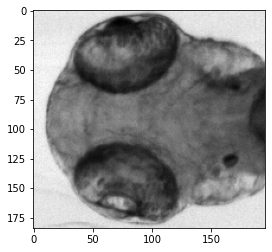

In [5]:
template = image[842:842+184, 528:528+196] 
plt.imshow(template, cmap="gray")

# I - Baseline execution
Let's call `matchTemplates` with the default parameters and record the execution time.

In [6]:
# Format the template into a list of tuple (label, templateImage)
listTemplate = [('head', template)]

%time Hits = matchTemplates(listTemplate, image, N_object=1, method=cv2.TM_CCOEFF_NORMED)

Hits

Wall time: 292 ms


,TemplateName,BBox,Score
0,head,"(528, 842, 196, 184)",1.0


In [7]:
%timeit Hits = matchTemplates(listTemplate, image, N_object=1, method=cv2.TM_CCOEFF_NORMED)

255 ms ± 53.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


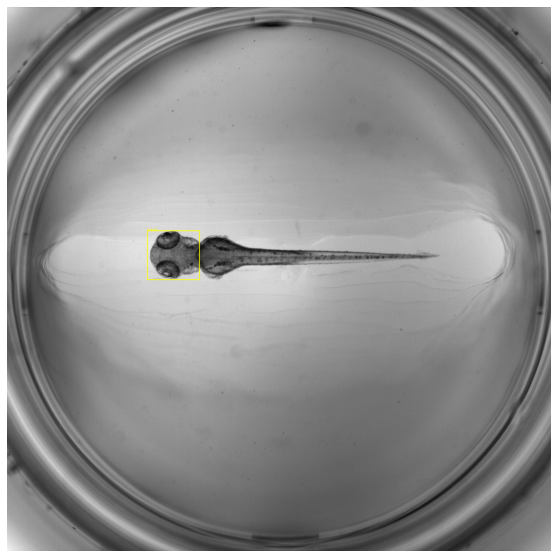

In [8]:
Overlay = drawBoxesOnRGB(image, Hits, showLabel=True)

plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)

# II - Using a limited search region
Let's now use a search region as we know that the specimen is mounted in a gel, so located in a rectangle centered in the middle of the image (in white).  
Let see the impact on the computation time.

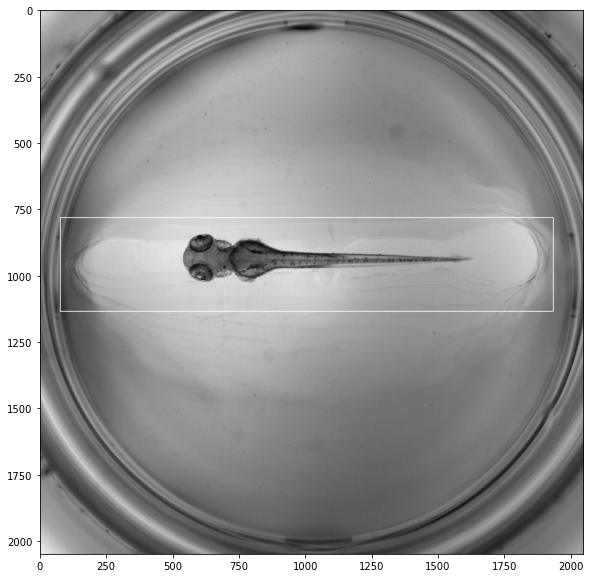

In [9]:
Overlay = image.copy()
cv2.rectangle(Overlay, (76, 781), (76+1856, 781+353), 255, 2)
plt.figure(figsize = (10,10))
plt.imshow(Overlay, cmap="gray")

In [10]:
# The search region is provided by the searchBox argument in format (x,y,width,height)
%timeit Hits = matchTemplates(listTemplate, image, N_object=1, method=cv2.TM_CCOEFF_NORMED, searchBox=(76,781,1856,353))
Hits

37.7 ms ± 8.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


,TemplateName,BBox,Score
0,head,"(528, 842, 196, 184)",1.0


__We get about 5x speed improvement !__  
The reason is simple, the comparison between the pixel intesities is now performed only for regions within the green area.
Which is a fraction of the original image size.  
Notice that the coordinates of the hit are still expressed in the full-size image coordinate system (no need to recaclulate).

# III - Downscaling the image
Using a search region is an easy way to speed up the algorithm if you have some a priori knowledge about the position of the object in the image.  
Yet it's not always the case you might still want to search the full region of a large image, and this quickly.  
Well many computer vision algorithm do not work on the full resolution image, to limit memory consumption.  
We can do the same for multi-template-matching.  
We can reduce the size from 2048x2048 to 512x512 for instance.

In [11]:
print("Original image size:", image.shape)

# Resize the image to 512x512
smallDim = 512,512
smallImage = cv2.resize(image, smallDim, interpolation = cv2.INTER_AREA) 
print("New image size: ", smallImage.shape)

Original image size: (2048, 2048)
New image size:  (512, 512)


Now that the image is smaller we need to redefine the template as well, by cropping the downsampled image for instance.  
The image being downsample by 4, we keep the same ratio for the new template size.  

Original template size: (184, 196)
New template size:  (46, 49)


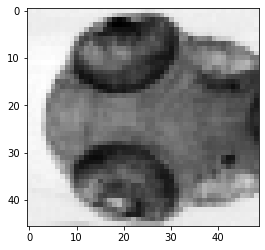

In [12]:
print("Original template size:", template.shape)

smallTemplate = smallImage[210:210+46, 131:131+49]
plt.imshow(smallTemplate, cmap="gray")

print("New template size: ", smallTemplate.shape)

As you can see from the resulting template, the resolution is worse, but it is still sufficient for the object-detection.


One thing to keep in mind is that the downsampling factor depends on the size of the object to find.  
Imagine we would downsample by a factor of 10 or 100, then the head region would be just a few pixel in the downsampled image and such that the chance to find it by template matching would decrease.  
Let's run now the detection with the downsampled images.

In [13]:
%timeit Hits = matchTemplates([("downsampled", smallTemplate)], smallImage, N_object=1, method=cv2.TM_CCOEFF_NORMED)
Hits

14.6 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


,TemplateName,BBox,Score
0,head,"(528, 842, 196, 184)",1.0


Now we gain about __12x speed improvement__ compared to the full resolution image !  
(for the template search only)

And now comes the major trick: because we performed the detection on downscale images, __we have to scale up the detected bounding-boxes__.  
Fortunately, there are such utilitary functions for bounding boxes in the gluoncv library.  
To install gluoncv, open a terminal in your active python environment and type `pip install gluoncv`.  
For this tutorial I'm using version 0.5.0.

In [14]:
# Alternatively you can directly install the gluoncv and mxnet packages to your environment by running this cell
!pip install gluoncv mxnet

  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)


ERROR: mxnet 1.6.0 has requirement numpy<1.17.0,>=1.8.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: mxnet 1.6.0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.24.0 which is incompatible.


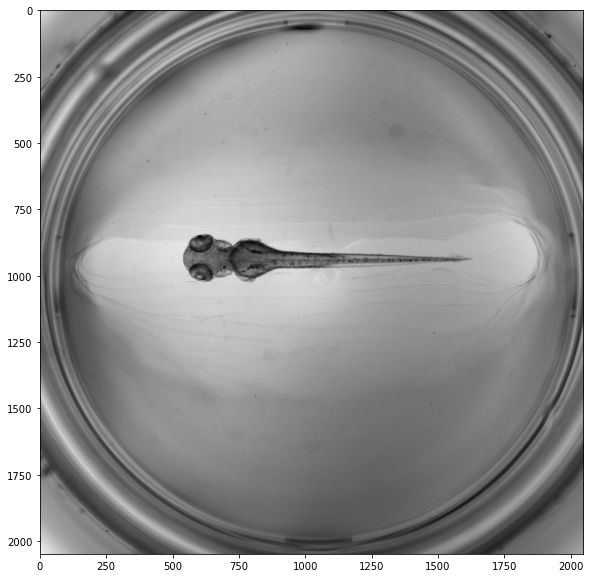

In [15]:
# Let's import the package first (it's quite big package so it might take a few seconds)
import gluoncv as gcv
import numpy as np

# Before upscaling the bounding boxes, we need to convert them from the x,y,width,height format to xmin,ymin,xmax,ymax
# There is also a function for that
BBoxes_xywh = np.array( Hits["BBox"].tolist() ) 
BBoxes_xyxy = gcv.utils.bbox.bbox_xywh_to_xyxy(BBoxes_xywh)

# Now we can rescale it
BBoxes = gcv.data.transforms.bbox.resize(BBoxes_xyxy, smallDim, image.shape[::-1] )

# And display it on top of the full resolution image
Overlay = gcv.utils.viz.cv_plot_bbox(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), BBoxes, scores=Hits["Score"].to_numpy(), thresh=0  )
plt.figure(figsize = (10,10))
plt.imshow(Overlay)

To sum up, we downscaled the image and the template, run the detection with the downscaled version, and finally rescaled the detected bounding boxes back to the full resolution image before display.  

In this tutorial, we showed 2 simple ways to speed-up execution:
- using a search region
- downscaling the image and the template, then rescale the bounding-boxes

We could think of combining both to have an even faster execution but it starts to be a bit code-heavy...   
Also even if the gain is just a fraction of second per image, if you would run the detection on thousands of images, this would make a real difference ! 
